# 06-01 웹캠 연결

## 웹캠 연결과 기본표시

In [1]:
import cv2

# 0번 장치: 기본 카메라 (노트북 내장 캠)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise RuntimeError('웹캠을 열 수 없습니다.')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow('Webcam', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q키 종료
        break

cap.release()
cv2.destroyAllWindows()


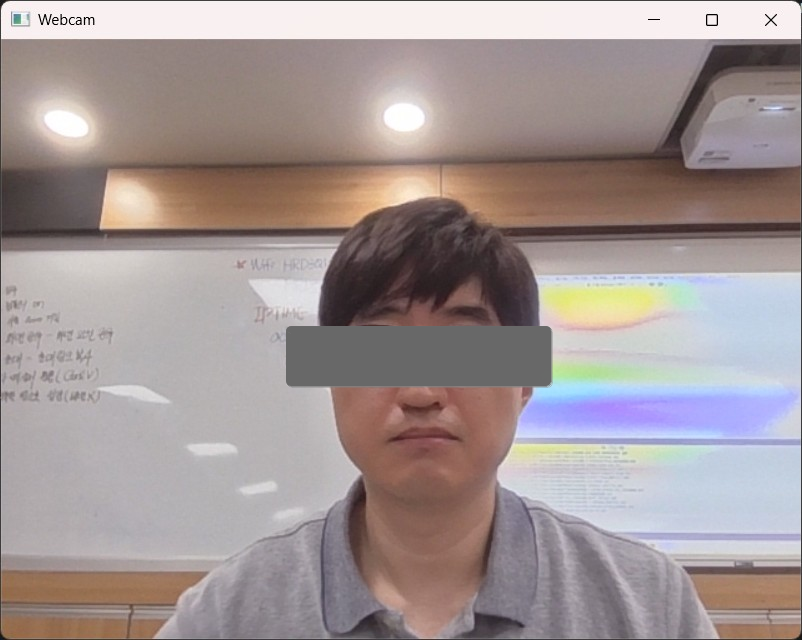

# 06-02 실시간 필터 적용

## 필터

In [2]:
import cv2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # (a) 그레이 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # (b) 블러
    blur = cv2.GaussianBlur(frame, (15, 15), 0)

    # (c) 엣지 검출
    edges = cv2.Canny(frame, 100, 200)

    # 보기 쉽게 합치기 (가로)
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    montage = cv2.hconcat([frame, blur, edges_bgr])

    cv2.imshow('Filters: Original | Blur | Edges', montage)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# 06-03 스냅샷 저장, 동영상 녹화

In [3]:
import cv2, os
import time

cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')   # 코덱
out = None
recording = False

os.makedirs('./result', exist_ok=True)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow('Webcam', frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):   # 종료
        break
    elif key == ord('s'): # 사진 찍기
        filename = f'./result/snapshot_{int(time.time())}.png'
        cv2.imwrite(filename, frame)
        print('저장:', filename)
    elif key == ord('r'): # 녹화 시작/정지
        if not recording:
            h, w = frame.shape[:2]
            out = cv2.VideoWriter('./result/record.mp4', fourcc, 20.0, (w, h))
            recording = True
            print('녹화 시작')
        else:
            recording = False
            out.release()
            print('녹화 종료')

    if recording:
        out.write(frame)  # 프레임 저장

cap.release()
if recording and out is not None:
    out.release()
cv2.destroyAllWindows()


저장: ./result/snapshot_1755847958.png
저장: ./result/snapshot_1755847965.png
녹화 시작
녹화 종료


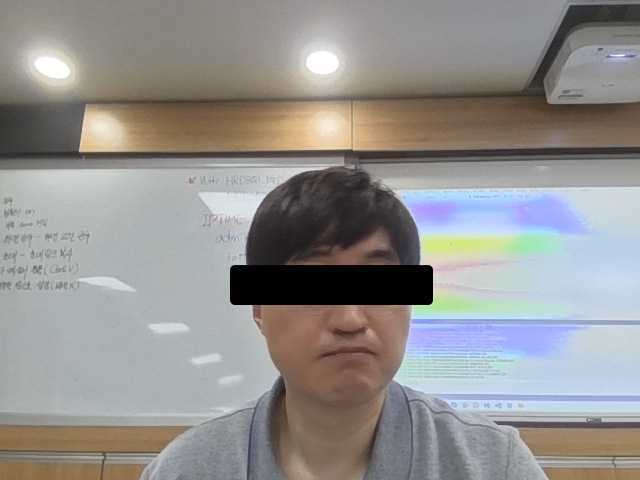

### 녹화 속도 개선 01

- 대신 FPS가 일치하지 않음. 10초를 녹화했는데 3초로 저장됨
- 파일 용량 큼

In [5]:
import cv2, time, os

# 카메라/영상 열기
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Windows면 DSHOW 백엔드가 종종 안정적
if not cap.isOpened():
    raise RuntimeError('웹캠을 열 수 없습니다.')

# 해상도/FPS 설정(가능한 경우)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

# 실제 캡처 FPS 읽기
cap_fps = cap.get(cv2.CAP_PROP_FPS)
if not cap_fps or cap_fps <= 1:
    cap_fps = 30.0  # 안전 기본값

# 빠른 저장용 코덱 & 크기
fourcc = cv2.VideoWriter_fourcc(*'MJPG')  # 빠름 (테스트용)
out = None
recording = False

os.makedirs('./result', exist_ok=True)
print('[키] r: 녹화 토글, q/ESC: 종료')

while True:
    ret, frame = cap.read()
    if not ret: break

    cv2.imshow('webcam', frame)
    key = cv2.waitKey(1) & 0xFF

    if key in (ord('q'), 27):
        break

    elif key == ord('r'):
        if not recording:
            h, w = frame.shape[:2]
            out = cv2.VideoWriter('./result/record.avi', fourcc, cap_fps, (w, h))
            recording = True
            print('녹화 시작 @', cap_fps, 'fps')
        else:
            recording = False
            out.release()
            out = None
            print('녹화 종료')

    if recording and out is not None:
        out.write(frame)  # 빠른 MJPG로 기록

cap.release()
if out: out.release()
cv2.destroyAllWindows()


[키] r: 녹화 토글, s: 스냅샷, q/ESC: 종료
녹화 시작 @ 30.00003000003 fps
녹화 종료


### 녹화 속도 개선 02

In [6]:
import cv2, time, os

# 카메라/영상 열기
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Windows면 DSHOW 백엔드가 종종 안정적
if not cap.isOpened():
    raise RuntimeError('웹캠을 열 수 없습니다.')

# 해상도/FPS 설정(가능한 경우)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

# 실제 캡처 FPS 읽기
cap_fps = cap.get(cv2.CAP_PROP_FPS)
if not cap_fps or cap_fps <= 1:
    cap_fps = 30.0  # 안전 기본값

# 빠른 저장용 코덱 & 크기
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 환경 따라 'avc1'이 더 잘 되는 경우도
out = None
recording = False

os.makedirs('./result', exist_ok=True)
print('[키] r: 녹화 토글, q/ESC: 종료')

while True:
    ret, frame = cap.read()
    if not ret: break

    cv2.imshow('webcam', frame)
    key = cv2.waitKey(1) & 0xFF

    if key in (ord('q'), 27):
        break

    elif key == ord('r'):
        if not recording:
            h, w = frame.shape[:2]
            out = cv2.VideoWriter('./result/record.mp4', fourcc, cap_fps, (w, h))
            recording = True
            print('녹화 시작 @', cap_fps, 'fps')
        else:
            recording = False
            out.release()
            out = None
            print('녹화 종료')

    if recording and out is not None:
        out.write(frame)  # 빠른 MJPG로 기록

cap.release()
if out: out.release()
cv2.destroyAllWindows()


[키] r: 녹화 토글, q/ESC: 종료
녹화 시작 @ 30.00003000003 fps
녹화 종료


### 개선 예제 4 — (고급) 쓰레드로 비동기 저장

In [10]:
import cv2
import time
import os
import threading
import queue

# -----------------------------
# 설정
# -----------------------------
SAVE_DIR = './result'
SAVE_NAME = 'record.mp4'
TARGET_FPS_FALLBACK = 30.0          # 캡처 FPS를 얻지 못할 때 기본 FPS
QUEUE_MAX = 300                      # 저장 큐 최대 길이(초당 30프레임이면 10초 버퍼)
DROP_IF_FULL = True                  # 큐가 가득 차면 프레임 드랍할지 여부(True=드랍, False=블로킹)
CODEC = 'mp4v'                       # 'mp4v' (보급형 H.264 대체), 빠른 점검은 'MJPG' + .avi 권장

# -----------------------------
# 저장 스레드 함수
# -----------------------------
def writer_thread(path, size_wh, fps, save_q: queue.Queue, stats_dict: dict):
    '''
    별도 스레드에서 큐의 프레임을 받아 파일로 저장
    path: 출력 파일 경로
    size_wh: (w, h)
    fps: 저장 FPS
    save_q: 프레임 큐 (np.ndarray(BGR))
    stats_dict: {'frames': int} 저장된 프레임 수 기록
    '''
    w, h = size_wh
    fourcc = cv2.VideoWriter_fourcc(*CODEC)
    vw = cv2.VideoWriter(path, fourcc, fps, (w, h))
    if not vw.isOpened():
        print('[Writer] VideoWriter open failed. Check codec/path.')
        return

    frames_written = 0
    while True:
        item = save_q.get()
        if item is None:
            break
        vw.write(item)
        frames_written += 1
    vw.release()
    stats_dict['frames'] = frames_written
    print(f'[Writer] done. frames_written={frames_written}')

# -----------------------------
# 메인
# -----------------------------
def main():
    os.makedirs(SAVE_DIR, exist_ok=True)

    # 웹캠 열기 (Windows면 CAP_DSHOW가 종종 안정적)
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    if not cap.isOpened():
        # 백엔드 지정 없이 재시도
        cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError('웹캠을 열 수 없습니다.')

    # (선택) 캡처 포맷과 해상도/FPS 힌트 설정
    # 카메라가 지원하면 MJPG로 캡처 FPS가 오를 수 있음
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
    cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_FPS, 30)

    # 실제 캡처 FPS 얻기(환경에 따라 0/1로 나올 수 있음 → fallback)
    cap_fps = cap.get(cv2.CAP_PROP_FPS)
    if not cap_fps or cap_fps <= 1:
        cap_fps = TARGET_FPS_FALLBACK
    print(f'[Info] Capture FPS (hint): {cap_fps:.2f}')

    cv2.namedWindow('webcam', cv2.WINDOW_NORMAL)

    save_q = None
    writer = None
    stats = {'frames': 0}
    recording = False
    t_start = None

    print('[키] r: 녹화 토글, q/ESC: 종료')
    while True:
        ret, frame = cap.read()
        if not ret:
            print('[Main] 캡처 실패. 종료합니다.')
            break

        # 미리보기(부하를 줄이고 싶으면 작은 크기로 축소해서 표시)
        cv2.imshow('webcam', frame)
        key = cv2.waitKey(1) & 0xFF

        if key in (ord('q'), 27):  # q or ESC
            break

        elif key == ord('r'):
            if not recording:
                # 녹화 시작
                h, w = frame.shape[:2]
                out_path = os.path.join(SAVE_DIR, SAVE_NAME)

                # 저장 큐/스레드 준비
                save_q = queue.Queue(maxsize=QUEUE_MAX)
                stats = {'frames': 0}
                writer = threading.Thread(
                    target=writer_thread,
                    args=(out_path, (w, h), cap_fps, save_q, stats),
                    daemon=True
                )
                writer.start()
                recording = True
                t_start = time.time()
                print(f'[Main] 녹화 시작 → {out_path} @ {cap_fps:.2f} fps')
            else:
                # 녹화 종료: 큐에 종료 신호(None) 넣고 스레드 합류
                recording = False
                if save_q is not None:
                    save_q.put(None)
                if writer is not None:
                    writer.join(timeout=5.0)
                elapsed = time.time() - (t_start or time.time())
                frames = stats.get('frames', 0)
                print(f'[Main] 녹화 종료. elapsed={elapsed:.2f}s, frames={frames}, ~{frames/max(elapsed,1e-6):.2f}fps')

        # 녹화 중이면 프레임을 큐에 투입
        if recording and save_q is not None:
            if DROP_IF_FULL:
                try:
                    save_q.put_nowait(frame.copy())
                except queue.Full:
                    # 큐가 가득 찼으면 드랍(프레임 끊김 대신 지연 악화를 방지)
                    pass
            else:
                # 블로킹 넣기(지연이 커져도 프레임을 모두 저장하고 싶을 때)
                save_q.put(frame.copy())

    # 종료 처리
    cap.release()
    cv2.destroyAllWindows()

    # 혹시 녹화 중 종료됐다면 마무리
    if recording and save_q is not None:
        save_q.put(None)
    if writer is not None:
        writer.join(timeout=5.0)
        print(f'[Main] 최종 저장 프레임: {stats.get("frames", 0)}')

if __name__ == '__main__':
    main()


[Info] Capture FPS (hint): 30.00
[키] r: 녹화 토글, q/ESC: 종료
[Main] 녹화 시작 → ./result\record.mp4 @ 30.00 fps
[Writer] done. frames_written=90
[Main] 녹화 종료. elapsed=9.01s, frames=90, ~9.99fps
[Main] 최종 저장 프레임: 90


### 녹화 속도 개선 03

In [7]:
import cv2, time, os

# 카메라/영상 열기
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Windows면 DSHOW 백엔드가 종종 안정적
if not cap.isOpened():
    raise RuntimeError('웹캠을 열 수 없습니다.')

# 해상도/FPS 설정(가능한 경우)
# 캡처 자체를 MJPG로 (카메라가 지원해야 함)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
cap.set(cv2.CAP_PROP_FPS, 30)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

# 실제 캡처 FPS 읽기
cap_fps = cap.get(cv2.CAP_PROP_FPS)
if not cap_fps or cap_fps <= 1:
    cap_fps = 30.0  # 안전 기본값

# 빠른 저장용 코덱 & 크기
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 환경 따라 'avc1'이 더 잘 되는 경우도
out = None
recording = False

os.makedirs('./result', exist_ok=True)
print('[키] r: 녹화 토글, q/ESC: 종료')

while True:
    ret, frame = cap.read()
    if not ret: break

    cv2.imshow('webcam', frame)
    key = cv2.waitKey(1) & 0xFF

    if key in (ord('q'), 27):
        break

    elif key == ord('r'):
        if not recording:
            h, w = frame.shape[:2]
            out = cv2.VideoWriter('./result/record.mp4', fourcc, cap_fps, (w, h))
            recording = True
            print('녹화 시작 @', cap_fps, 'fps')
        else:
            recording = False
            out.release()
            out = None
            print('녹화 종료')

    if recording and out is not None:
        out.write(frame)  # 빠른 MJPG로 기록

cap.release()
if out: out.release()
cv2.destroyAllWindows()


[키] r: 녹화 토글, q/ESC: 종료
녹화 시작 @ 30.00003000003 fps
녹화 종료


### 실제 속도 녹화

In [8]:
import cv2, time, os

def measure_fps(cap, seconds=1.5):
    '''cap에서 seconds 동안 프레임을 읽어 실측 FPS를 추정'''
    start = time.time()
    cnt = 0
    while time.time() - start < seconds:
        ret, _ = cap.read()
        if not ret:
            break
        cnt += 1
    dur = max(time.time() - start, 1e-6)
    fps = cnt / dur
    # 스트림 위치를 다시 처음(또는 직전 위치)으로 되돌림
    # 웹캠은 되감기가 안 되니 무시. 파일이면 cap.set 사용 가능.
    return max(fps, 1.0)

# --- 웹캠 열기 ---
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Windows라면 DSHOW가 종종 안정적
if not cap.isOpened():
    raise RuntimeError('웹캠을 열 수 없습니다.')

# 캡처 성능 개선(가능한 경우)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))  # MJPG 캡처
cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)

# 표시용 윈도우
cv2.namedWindow('webcam', cv2.WINDOW_NORMAL)

fourcc_fast = cv2.VideoWriter_fourcc(*'MJPG')   # 빠른 테스트용(용량 큼, AVI)
fourcc_h264 = cv2.VideoWriter_fourcc(*'mp4v')   # 보급형 H.264(환경 따라 다름)

out = None
recording = False
save_path = './result/record.mp4'
os.makedirs('./result', exist_ok=True)

print('[키] r: 녹화 토글, q/ESC: 종료')
while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow('webcam', frame)
    key = cv2.waitKey(1) & 0xFF

    if key in (ord('q'), 27):
        break

    elif key == ord('r'):
        if not recording:
            # 녹화 시작 직전에 '실제 처리 가능한 FPS'를 짧게 계측
            print('FPS 측정 중...')
            fps_meas = measure_fps(cap, seconds=1.2)
            # 계측 직후 한 프레임 읽어 화면 끊김 방지
            ret, frame = cap.read()
            if not ret:
                continue

            h, w = frame.shape[:2]

            # 빠른 확인용: MJPG AVI (속도↑)
            # out = cv2.VideoWriter('./result/record.avi', fourcc_fast, fps_meas, (w, h))
            # 최종본: mp4v (환경 따라 'avc1'이 더 잘 재생될 수 있음)
            out = cv2.VideoWriter(save_path, fourcc_h264, fps_meas, (w, h))

            recording = True
            t0 = time.time()
            frames_written = 0
            print(f'녹화 시작 @ {fps_meas:.2f} fps')
        else:
            recording = False
            if out:
                out.release()
                out = None
            elapsed = time.time() - t0
            print(f'녹화 종료: 저장 프레임 {frames_written}, '
                  f'실제 경과 {elapsed:.2f}s, '
                  f'파일 길이 ≈ {frames_written/max(1e-6, cap.get(cv2.CAP_PROP_FPS) or 30):.2f}s (플레이어 해석에 따라 다름)')

    if recording and out is not None:
        out.write(frame)
        frames_written += 1

cap.release()
if out:
    out.release()
cv2.destroyAllWindows()


[키] r: 녹화 토글, q/ESC: 종료
FPS 측정 중...
녹화 시작 @ 10.05 fps
녹화 종료: 저장 프레임 99, 실제 경과 9.92s, 파일 길이 ≈ 3.30s (플레이어 해석에 따라 다름)
